In [1]:
import sys
import numbers
import time
import math
import datetime as dt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
from scipy import stats as ss
%matplotlib inline
from matplotlib import pyplot as plt
import statsmodels
import sktime
import metrics
import sklearn
from functools import reduce
import pmdarima as pmd
import statsmodels.api as sm
from scipy.stats import normaltest
import seaborn as sns
import plotly as ply
import cufflinks as cf
import chart_studio.plotly as py
import plotnine as p9
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [2]:
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.width', 80)
pd.set_option('display.max_columns', 12)

In [3]:
hour = pd.read_csv('data/hour.csv')
hour_c = pd.read_csv('data/hour_clean.csv')

In [4]:
hour['ds'] = pd.to_datetime(hour['ds'], format = '%Y-%m-%d %H:%M')
hour_c['ds'] = pd.to_datetime(hour_c['ds'], format = '%Y-%m-%d %H:%M')

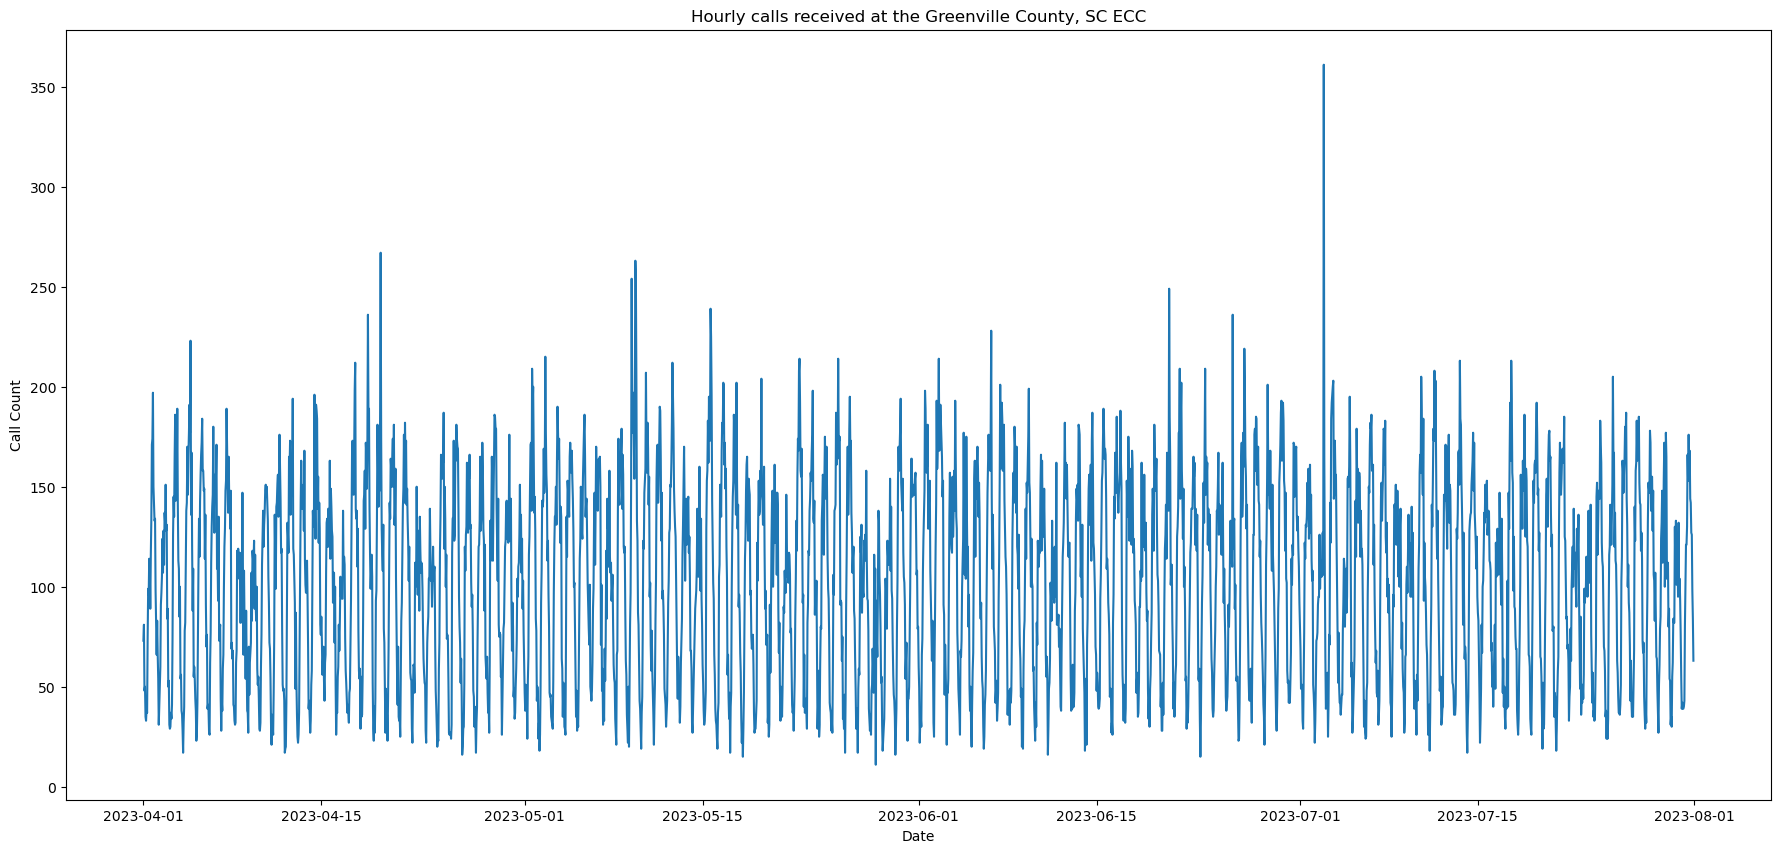

In [5]:
plt.figure(figsize=(22,10))
plt.plot(hour.ds, hour.gco)
plt.title("Hourly calls received at the Greenville County, SC ECC")
plt.xlabel("Date")
plt.ylabel("Call Count")
plt.show()

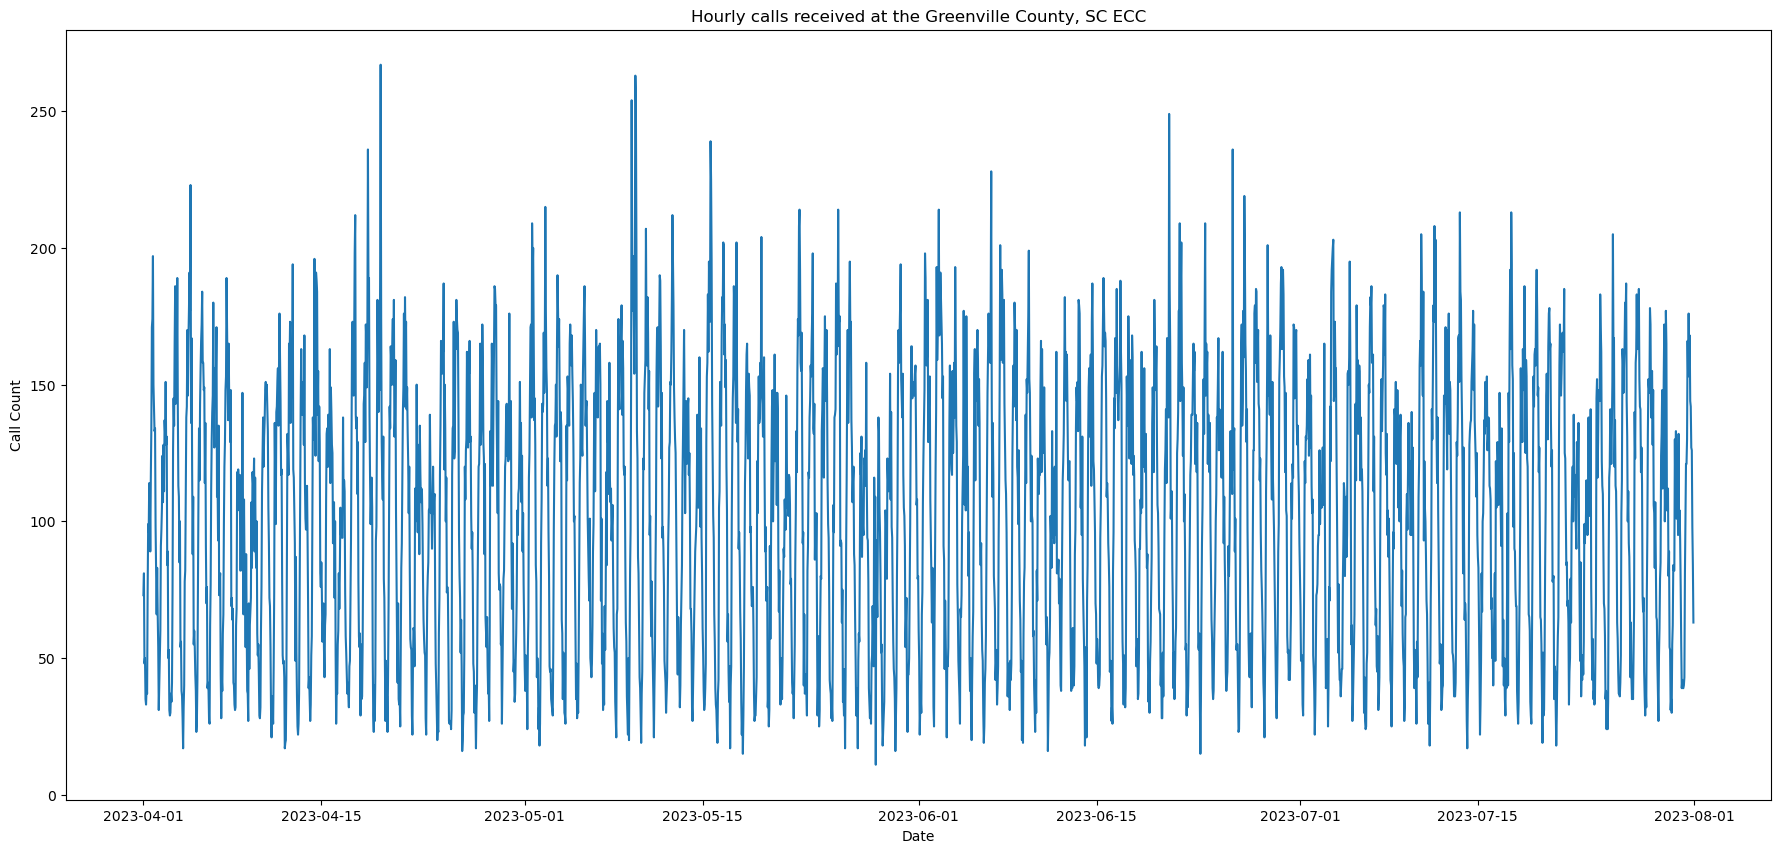

In [6]:
plt.figure(figsize=(22,10))
plt.plot(hour_c.ds, hour_c.gco)
plt.title("Hourly calls received at the Greenville County, SC ECC")
plt.xlabel("Date")
plt.ylabel("Call Count")
plt.savefig('gcoh.png', dpi=300, bbox_inches='tight')
plt.show()

In [7]:
season_gcoh = seasonal_decompose(hour['gco'], model='additive', period=24)
season_gcoh2 = seasonal_decompose(hour_c['gco'], model='additive', period=24)

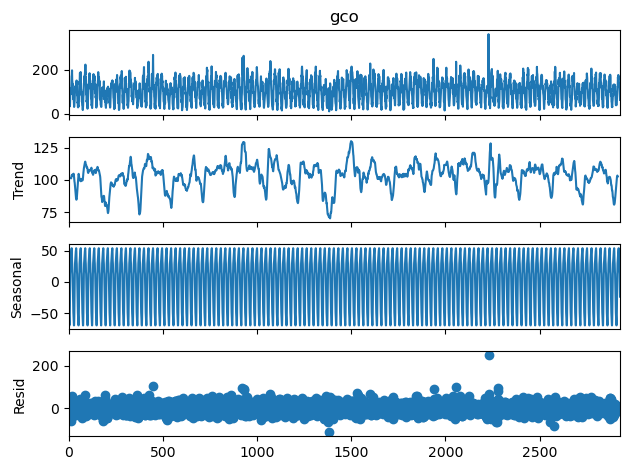

In [8]:
season_gcoh.plot()
plt.show()

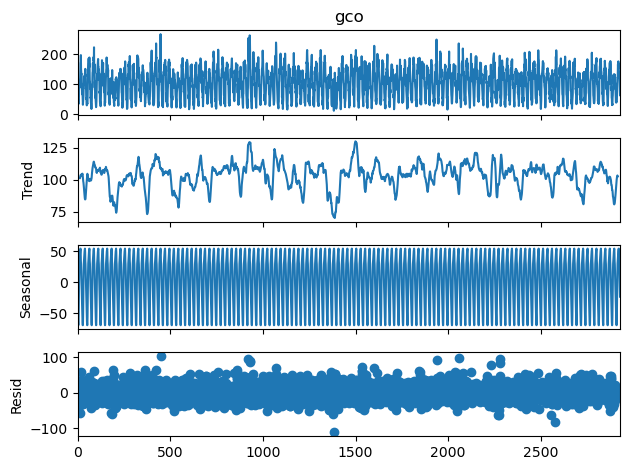

In [9]:
season_gcoh2.plot()
plt.savefig('gcoh_decomp.png', dpi=300, bbox_inches='tight')
plt.show()

In [10]:
adftest_gcoh = adfuller(hour['gco'], autolag='AIC', regression='ct')
print("ADF Test Results")
print("Null Hypothesis: The series has a unit root (non-stationary)")
print("ADF-Statistic:", adftest_gcoh[0])
print("P-Value:", adftest_gcoh[1])
print("Number of lags:", adftest_gcoh[2])
print("Number of observations:", adftest_gcoh[3])
print("Critical Values:", adftest_gcoh[4])
print("Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary")

ADF Test Results
Null Hypothesis: The series has a unit root (non-stationary)
ADF-Statistic: -8.655924862828124
P-Value: 2.2018516371946533e-12
Number of lags: 27
Number of observations: 2900
Critical Values: {'1%': -3.9618951443829182, '5%': -3.412005007330108, '10%': -3.1279420538308256}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


In [11]:
adftest_gcoh2 = adfuller(hour_c['gco'], autolag='AIC', regression='ct')
print("ADF Test Results")
print("Null Hypothesis: The series has a unit root (non-stationary)")
print("ADF-Statistic:", adftest_gcoh2[0])
print("P-Value:", adftest_gcoh2[1])
print("Number of lags:", adftest_gcoh2[2])
print("Number of observations:", adftest_gcoh2[3])
print("Critical Values:", adftest_gcoh2[4])
print("Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary")

ADF Test Results
Null Hypothesis: The series has a unit root (non-stationary)
ADF-Statistic: -8.936161017412871
P-Value: 5.062049778868049e-13
Number of lags: 28
Number of observations: 2899
Critical Values: {'1%': -3.961896223560848, '5%': -3.4120055302986687, '10%': -3.1279423617033797}
Note: If P-Value is smaller than 0.05, we reject the null hypothesis and the series is stationary


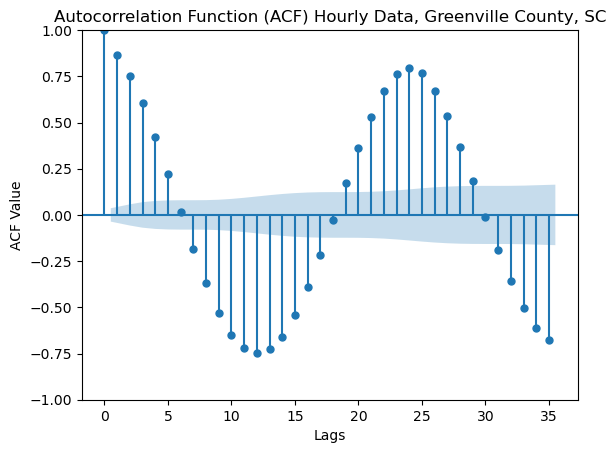

In [12]:
plot_acf(hour_c['gco'])
plt.title("Autocorrelation Function (ACF) Hourly Data, Greenville County, SC")
plt.xlabel("Lags")
plt.ylabel("ACF Value")
plt.show()

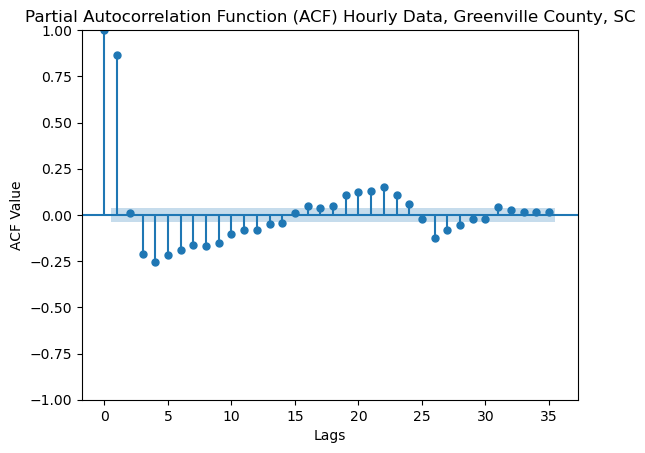

In [13]:
plot_pacf(hour_c['gco'])
plt.title("Partial Autocorrelation Function (ACF) Hourly Data, Greenville County, SC")
plt.xlabel("Lags")
plt.ylabel("ACF Value")
plt.show()

In [14]:
gcoh = pd.DataFrame(hour_c, columns=['ds', 'gco'])
tr_gcoh = gcoh[:2184]
tst_gcoh = gcoh[2184:]

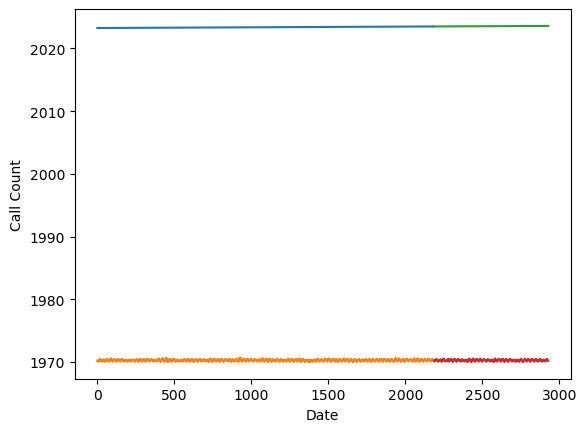

In [15]:
plt.plot(tr_gcoh)
plt.plot(tst_gcoh)
plt.title = ("Test and Training Split of Hourly Data for Greenville County, SC")
plt.xlabel("Date")
plt.ylabel("Call Count")
plt.show()

In [16]:
tr_gcoh_model1 = pmd.auto_arima(tr_gcoh['gco'],
                      m=24,               # frequency of series
                      seasonal=True,  # TRUE if seasonal series
                      d=None,             # let model determine 'd'
                      test='adf',         # use adftest to find optimal 'd'
                      start_p=0, start_q=0, # minimum p and q
                      max_p=12, max_q=12, # maximum p and q
                      D=None,             # let model determine 'D'
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

# print model summary
print(tr_gcoh_model1.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[24] intercept   : AIC=inf, Time=4.81 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=23255.804, Time=0.12 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=19993.646, Time=5.57 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=21071.975, Time=2.70 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=26925.185, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=20216.196, Time=0.16 sec
 ARIMA(1,0,0)(2,0,0)[24] intercept   : AIC=19861.894, Time=26.14 sec
 ARIMA(1,0,0)(2,0,1)[24] intercept   : AIC=inf, Time=45.70 sec
 ARIMA(1,0,0)(1,0,1)[24] intercept   : AIC=inf, Time=7.41 sec
 ARIMA(0,0,0)(2,0,0)[24] intercept   : AIC=inf, Time=37.70 sec
 ARIMA(2,0,0)(2,0,0)[24] intercept   : AIC=19773.040, Time=37.87 sec
 ARIMA(2,0,0)(1,0,0)[24] intercept   : AIC=19929.182, Time=7.11 sec
 ARIMA(2,0,0)(2,0,1)[24] intercept   : AIC=inf, Time=52.44 sec
 ARIMA(2,0,0)(1,0,1)[24] intercept   : AIC=inf, Time=14.33 sec
 ARIMA(3,0,0)(2,0,0)[24] intercept 

In [17]:
gcoh_pred1 = pd.DataFrame(tr_gcoh_model1.predict(n_periods=len(tst_gcoh)), index=tst_gcoh.index)
gcoh_pred1.columns = ['predicted_volume']
gcoh_pred1

,predicted_volume
2184,77.88
2185,72.15
2186,68.04
2187,59.37
2188,53.85
...,...
2923,116.10
2924,115.89
2925,114.55
2926,112.42


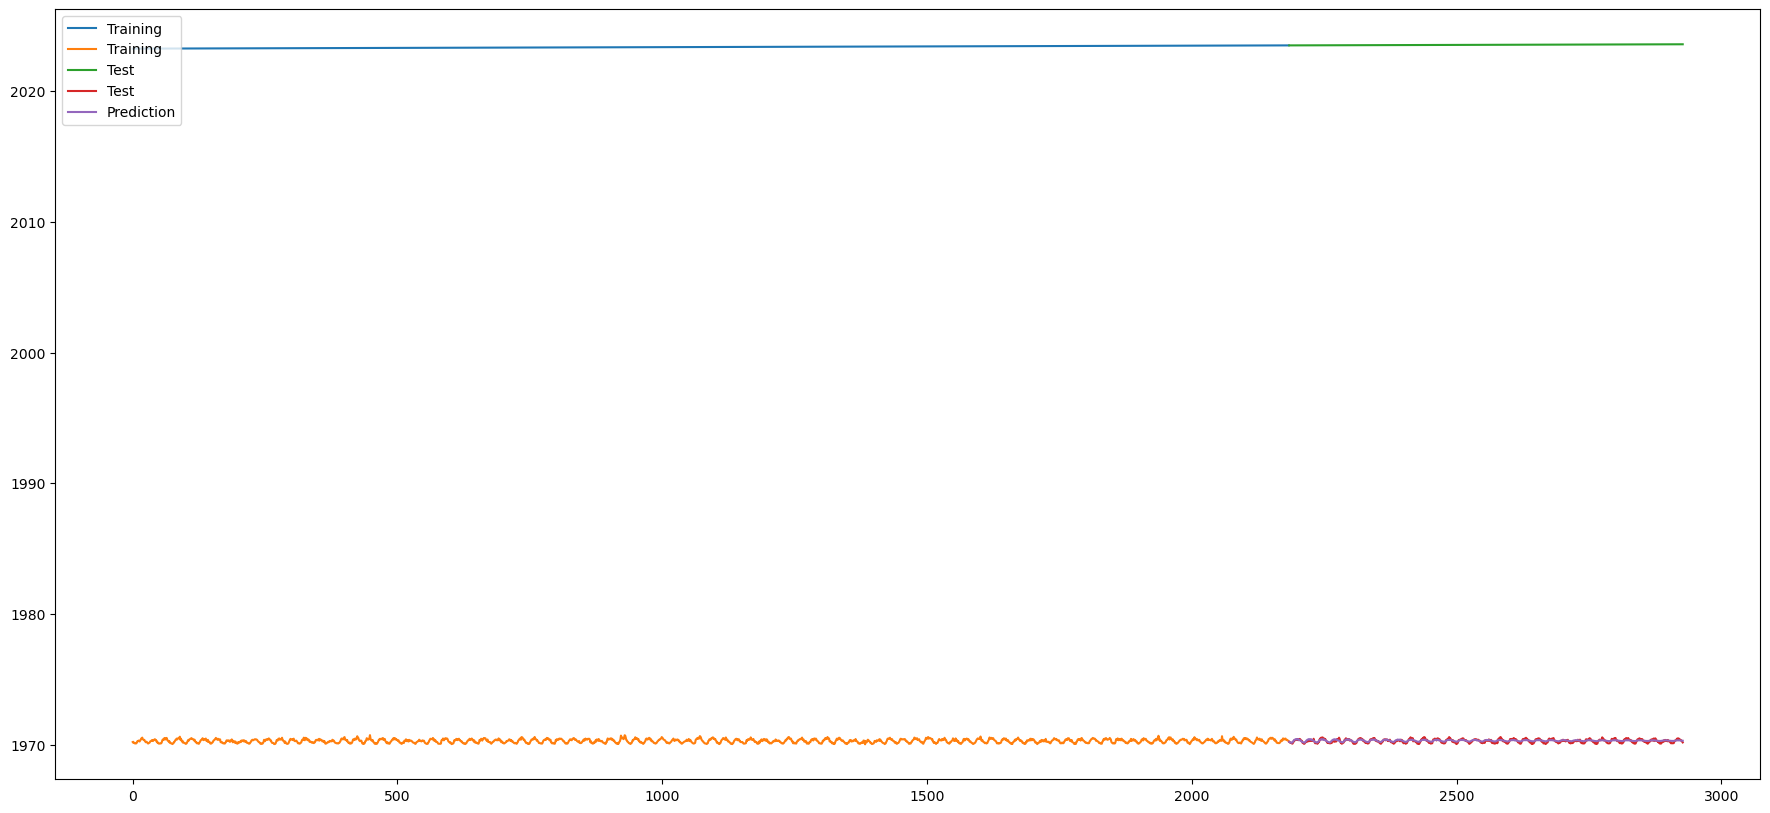

In [18]:
plt.figure(figsize=(22,10))
plt.plot(tr_gcoh, label="Training")
plt.plot(tst_gcoh, label = "Test")
plt.plot(gcoh_pred1, label = "Prediction")
plt.legend(loc="upper left")
plt.savefig("gcoh_arima.png")
plt.show()

In [19]:
gcoh_mae = mean_absolute_error(tst_gcoh['gco'], gcoh_pred1)
gcoh_mae

30.01206474527285

In [20]:
gcoh_mse = mean_squared_error(tst_gcoh['gco'], gcoh_pred1)
gcoh_mse

1272.5190494678966

In [21]:
gcoh_r2 = r2_score(tst_gcoh['gco'], gcoh_pred1)
gcoh_r2

0.43115222832405165

In [22]:
from permetrics import RegressionMetric
list_metrics = ["MSE","MAE","MedAE","MAPE", "SMAPE", "MASE", "RMSE", "R2"]

In [23]:
gcoh_true = tst_gcoh['gco'].tolist()
gcoh_pred = gcoh_pred1['predicted_volume'].tolist()

gcoh_eval = RegressionMetric(gcoh_true, gcoh_pred)

gcoh_reslist = []

for metric in list_metrics:
    gcoh_reslist.append(gcoh_eval.get_metric_by_name(metric))

print(gcoh_reslist)

[{'MSE': 1272.5190494678966}, {'MAE': 30.01206474527285}, {'MedAE': 28.127178511932648}, {'MAPE': 0.4871886923910233}, {'SMAPE': 0.16827996156628539}, {'MASE': 1.5762327069864794}, {'RMSE': 35.67238497028053}, {'R2': 0.43115222832405165}]
